<a href="https://colab.research.google.com/github/manularrea/Spark/blob/main/practica/Practica_SparkCore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Nombre:** Manuela <br>
**Apellidos:** Larrea Gómez
# Ejercicio 1 – Spark Core (6 puntos)
<hr>
<P>
Haciendo uso de Spark Core, resuelve las 8 consultas siguientes (0,75 puntos por
consulta). En principio, las consultas no siguen ningún orden específico de dificultad </P>

## Requerimientos del sistema

* Versión de Python: 3.11.4 o superior


## Configuración de ambiente de Spark

In [2]:
from pathlib import Path

installation_folder = Path("/content/spark-3.5.0-bin-hadoop3")

if not installation_folder.exists():

  # Install Java locally
  !apt-get install openjdk-8-jdk-headless -qq > /dev/null

  # Download & decompress Spark
  !wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz -O spark-3.5.0-bin-hadoop3.tgz
  !tar xf spark-3.5.0-bin-hadoop3.tgz

  # Install finspark
  %pip install -q findspark

  # Setup required environment variables
  import os
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

  print("Spark setup finished!")

else:
  print("Skipping Spark setup")

Spark setup finished!


## Preparar el contexto de Spark

In [3]:
# Import findpsark
import findspark

# Configure the environment
findspark.init()

# Import the Spark components required for the context creation
from pyspark import SparkConf, SparkContext

# Configure and create the context
conf = SparkConf()
conf = conf.setAppName('mds-session')
conf = conf.setMaster('local[*]')
sc = SparkContext.getOrCreate(conf=conf)

## Importación de la data y librerías complementarias

In [4]:
import re

In [86]:
albums = sc.textFile('./data/albums.tsv')
artists = sc.textFile('./data/artists.tsv')
songs = sc.textFile('./data/songs.tsv')


In [145]:
def splitLine(line):
    return line.split('\t')


In [146]:
albums = albums.map(splitLine)
artists = artists.map(splitLine)
songs = songs.map(splitLine)

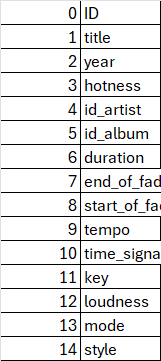


## 1.  ¿Cuál es el estilo más lento *(tempo)* en media?

In [150]:
'''
Descripción: Esta función analiza una línea de datos de texto formateado y extrae el estilo de la canción y el tempo.
Parámetros:
line (str): La línea de datos de texto formateado a analizar.
Devuelve:
Una tupla que contiene el estilo de la canción y una tupla que representa el tempo. En esta segunda tupla, el número 1 representa el número de
repeticiones del estilo (Util para la función Reduce que se utilizará más adelante)
'''

def getSongStyle(line):
  style = line[14]
  tempo = float(line[9])
  return (style, (1, tempo))

song_styles= songs.map(getSongStyle)

In [151]:
# Obtiene el recuento total de cada estilo de canción y el tempo total
style_sum_rdd = song_styles.reduceByKey(lambda conteo , tempo: (conteo[0] + tempo[0], conteo[1] + tempo[1]))

In [152]:
#Cálculo de la media del tempo por estilo (songs[0]: Estilo, songs [1][1]: Tempo total por ese estilo, songs[1][0]: Conteo total de repeticiones de dicho estilo )
media_style_tempo = style_sum_rdd.map(lambda songs: (songs[0], songs[1][1] / songs[1][0] if songs[1][0] != 0 else 0))


In [153]:
# Devuelve el estilo con el tempo más bajo utilizando la operación min() de Python..
slowest_tempo_style = min(media_style_tempo.toLocalIterator(), key=lambda s: s[1])
print(f'El estilo con el tempo más bajo es {slowest_tempo_style[0]}, con un tempo promedio de {slowest_tempo_style[1]} BPM.')

El estilo con el tempo más bajo es rebetika, con un tempo promedio de 47.447 BPM.


## 2. ¿Cuales son los 5 artistas, ubicados en UK (cualquier territorio de UK), con mayor número de canciones en escala menor (mode = 1)?

In [154]:
def getArtistsLocation(line):
  artist_id = line[0]
  artist_name = line[1]
  artist_location = line[4]
  return (artist_location, (artist_id, artist_name))

artists_location= artists.map(getArtistsLocation)

In [155]:
# Se crea la función filterUKArtists, que a través del uso de regex, filtra el dataset para obtener los artistas ubicados en el UK.
def filterUKArtists(artist_info):
    artist_location = artist_info[0]
    artist_id = artist_info[1][0]
    artist_name = artist_info[1][1]

    # Se crea una expresión regular con los nombres de los países del reino unido y algunas principales ciudades/zonas.
    uk_regex = re.compile(r'\b(?:united kingdom|uk|england|scotland|wales|northern ireland|london|edinburgh|cardiff|belfast|birmingham|manchester|liverpool)\b', re.IGNORECASE)

    # Check if the location matches the regex
    if uk_regex.search(artist_location):
        return (artist_id, artist_name, artist_location)
    return None

#Se obtienen los artistas junto con su ubicación
artists_rdd = artists.map(getArtistsLocation)

# Se filtra el rdd de artistas para obtener aquellos que cumplan la expresión regular definida en la función filterUKArtists.
uk_artists = artists_rdd.map(filterUKArtists).filter(lambda x: x is not None)


In [159]:
# Función para obtener los modos de las canciones y el ID del artista
def getSongsMode(line):
    artist_id = line[4]
    song_mode = int(line[13])
    return (artist_id, song_mode)

songs_rdd = songs.map(getSongsMode)

In [160]:
# Unificamos el rdd que contiene los artistas de UK y sus canciones.
uk_artists_and_songs = uk_artists.join(songs_rdd)

In [161]:
# Filtramos el rdd para obtener únicamente las canciones en escala menor
minor_songs = uk_artists_and_songs.filter(lambda songs: songs[1][1] == 1)

In [162]:
# Se realiza el mapeo del nombre del artista
song_counts_rdd = minor_songs.map(lambda songs: (songs[1][0], 1)).reduceByKey(lambda elemento1, elemento2: elemento1 + elemento2)

In [163]:
# Crea una lista con los primeros 5 elementos del rdd song_counts_rdd
top_5_artists = song_counts_rdd.takeOrdered(5, key=lambda songs: -songs[1])

In [165]:
print('Los 5 artistas, ubicados en el UK, con mayor número de canciones en escala menor son los siguientes:')
for i in range(0,5):
  print(f'\xa0 {i+1}. {top_5_artists[i][0]}, con {top_5_artists[i][1]} canciones')


Los 5 artistas, ubicados en el UK, con mayor número de canciones en escala menor son los siguientes:
  1. SNOWPATROL, con 11 canciones
  2. Phil Collins, con 9 canciones
  3. The Rolling Stones, con 7 canciones
  4. Radiohead, con 7 canciones
  5. Seal, con 6 canciones


## 3. Desde 1970 hasta hoy, ¿las canciones son más rápidas (tempo), altas (loudness) y cortas (duration) en media? Ordena los resultados por año ascendente.

In [169]:
def getSongsInfo(line):
  datetime = int(line[2])
  tempo = float(line[9])
  loudness = float(line[11])
  duration = float(line[6])

  return (datetime, (tempo, loudness, duration))


In [170]:
songs_time = songs.map(getSongsInfo)

In [171]:
# Se filtra la información de las canciones para obtener únicamente aquellas cuyo año es => 1970 y posteriormente se organizan
songs_over_1970 = songs_time.filter(lambda songs: songs[0] >= 1970)
songs_over_1970 = songs_over_1970.sortBy(lambda songs: songs[0])


In [172]:
def getMean(rdd, index):
    return (
        rdd.map(lambda el: (el[0], (el[1][index], 1)))
           .reduceByKey(lambda el1, el2: (el1[0] + el2[0], el1[1] + el2[1]))
           .map(lambda el: (el[0], el[1][0] / el[1][1]))
    )

In [173]:
tempo = getMean(songs_over_1970, 0)
loudness = getMean(songs_over_1970, 1)
duration = getMean(songs_over_1970, 2)

In [175]:
song_info = tempo.join(loudness).join(duration).sortBy(lambda el: el[0])

In [176]:
simplified_rdd = song_info.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][1])) #x[1][0][0]: Tempo, x[1][0][1]: Loudness, x[1][1]: Duration

In [177]:
data = simplified_rdd.collect()

A pesar de que collect es una acción muy costosa computacionalmente (dado que colecciona todos los elementos del rdd y los envía al driver), es necesaria dadas las características de la consulta.

Para mitigar los recursos demandados por un .collect(), se realiza después realizar las acciones de filtrado y reducción del tamaño del rdd.

Ahora bien, ya teniendo los datos en el driver y teniendo en cuenta que todo queda en manos de los recursos de RAM;  podremos hacer uso de herramientas de visualización (librería) para lograr identificar patrones temporales.

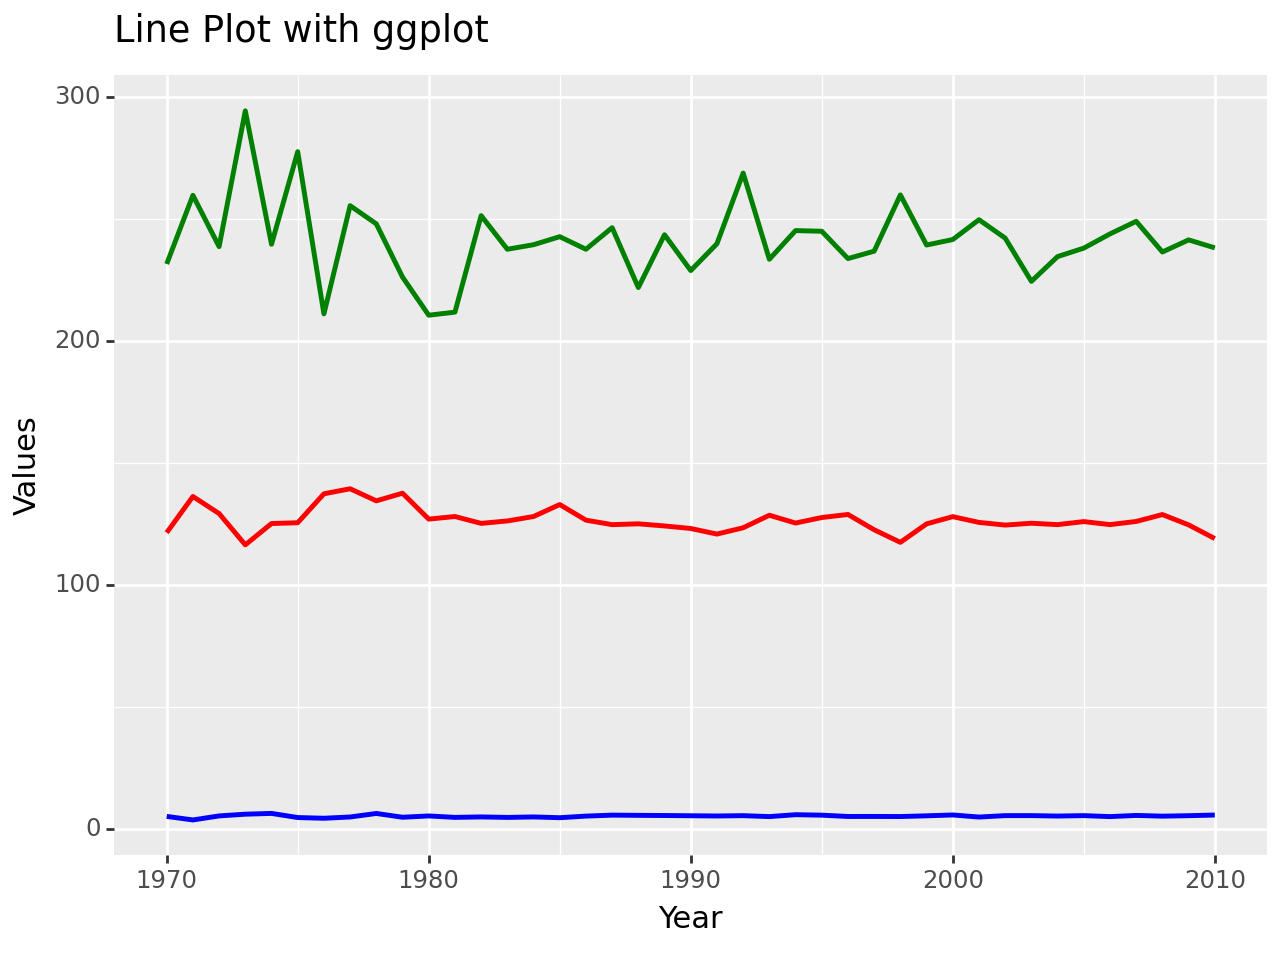

In [178]:
from plotnine import ggplot, aes, geom_line, labs, annotate

# Unpack data for plotting
years, tempo, loudness, duration = zip(*data)

# Create a plot using ggplot
plt1 = (
  ggplot()
  + aes(x='years')
  + geom_line(aes(y='tempo'), color='red', size=1, linetype='solid')
  + geom_line(aes(y='loudness'), color='blue', size=1, linetype='solid')
  + geom_line(aes(y='duration'), color='green', size=1, linetype='solid')
  + labs(title='Line Plot with ggplot', y='Values', x='Year', color='Legend')
)

# Show the plot
print(plt1)


## 4. ¿Cuál es el estilo que más abusa del efecto de fade out (mayor número de segundos entre el inicio del fade out y el final de la canción)?

In [180]:
def getSongFades(line):
  style = line[14]
  fade_out = float(line[8]) - float(line[7])
  return(style, (1, fade_out))


fade_out = songs.map(getSongFades)

In [184]:
# Obtiene el recuento total de cada estilo de canción y el fadeout
fadeout_sum_rdd = fade_out.reduceByKey(lambda conteo , fadeout: (conteo[0] + fadeout[0], conteo[1] + fadeout[1]))

In [185]:
#Cálculo de la media del tempo por estilo (songs[0]: Estilo, songs [1][1]: Tempo total por ese estilo, songs[1][0]: Conteo total de repeticiones de dicho estilo )
media_fadeout = fadeout_sum_rdd.map(lambda songs: (songs[0], songs[1][1] / songs[1][0] if songs[1][0] != 0 else 0))


In [186]:
# Devuelve el estilo con el tempo más bajo utilizando la operación min() de Python..
highest_fadeout_style = max(media_fadeout.toLocalIterator(), key=lambda s: s[1])
print(f'El estilo que más abusa del efecto fade out es {highest_fadeout_style[0]}, con un tiempo promedio de {highest_fadeout_style[1]} BPM.')


El estilo que más abusa del efecto fade out es qawwali, con un tiempo promedio de 778.567 BPM.


## 5. ¿Cual es la canción más popular (hotness) de los 5 artistas más popular (hotness)?

In [193]:
def getHotArtists(line):
  artist_id = line[0]
  artist_name = line[1]
  hotness = line[2]

  if hotness=='NA':
    return (artist_id, (artist_name, 0.0))
  return (artist_id, (artist_name, hotness))

hottest_artists = artists.map(getHotArtists).sortBy(lambda el: el[1][1], ascending = False)
top_5_artists = hottest_artists.take(5)
top_5_artists_rdd = sc.parallelize(top_5_artists)


In [194]:
print(top_5_artists)

[('ARRH63Y1187FB47783', ('Kanye West', '1.082502557')), ('ARF8HTQ1187B9AE693', ('Daft Punk', '1.021255588')), ('ARTDQRC1187FB4EFD4', ('Black Eyed Peas', '1.005941966')), ('ARS54I31187FB46721', ('Taylor Swift', '0.922412443')), ('ARJ7KF01187B98D717', ('Coldplay', '0.916053228'))]


In [196]:
def getHotSongs(line):
  artist_id = line[4]
  song_title = line[1]
  hotness = line[3]

  if hotness=='NA':
    return (artist_id, (0.0, song_title))
  return (artist_id, (float(hotness), song_title))

songs_hotness = songs.map(getHotSongs).sortBy(lambda el: el[1], ascending = False)

In [197]:
song_hotness_artist= songs_hotness.join(top_5_artists_rdd)

In [198]:
hottest_song_by_artist = song_hotness_artist.reduceByKey(lambda item1, item2: (max(item1[0], item2[0]), item1[1] if item1[0] > item2[0] else item2[1]))
hottest_song_artist = hottest_song_by_artist.map(lambda item: (item[1][0][1], item[1][1])).collect()

In [199]:
print('La canción más popular de los 5 artistas más populares son, respectivamente:')
for i in range(0,5):
  print(f"\xa0 {i+1}. '{hottest_song_artist[i][0]}' de {hottest_song_artist[i][1]}")

La canción más popular de los 5 artistas más populares son, respectivamente:
  1. 'Da Funk' de ('Daft Punk', '1.021255588')
  2. 'One I Love' de ('Coldplay', '0.916053228')
  3. 'The Way I Loved You' de ('Taylor Swift', '0.922412443')
  4. 'Street Lights' de ('Kanye West', '1.082502557')
  5. 'Let's Get It Started' de ('Black Eyed Peas', '1.005941966')


## 6. ¿Cuál es el álbum más largo (duration) de todo el set de datos? Incluye en la respuesta el nombre del álbum y de su artista.

In [206]:
def getSongDuration(line):
  album_id = line[5]
  duration = float(line[6])
  return (album_id, duration)

album_duration = songs.map(getSongDuration)

In [208]:
album_duration_sum = album_duration.reduceByKey(lambda duration1, duration2: duration1+duration2)